In [269]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [270]:
def f(x):
  return 3*x**2 - 4*x + 5

In [271]:
f(0)

5

In [272]:
f(math.sqrt(3))

7.0717967697244895

In [273]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

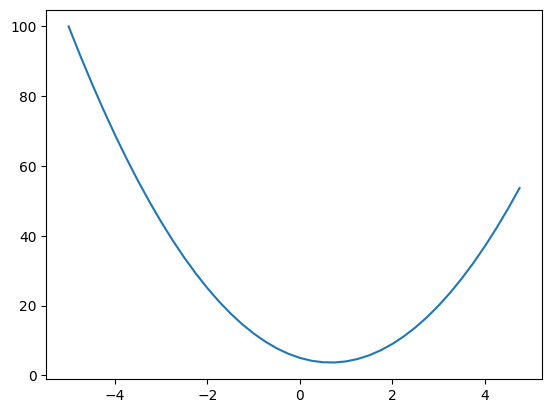

In [274]:
plt.plot(xs, ys)
plt.show()

In [275]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [276]:
h = 1e-6
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [277]:
h = 1e-6
x = -3.0
(f(x + h) - f(x)) / h

-21.999997002808414

In [278]:
h = 1e-6
x = 2 / 3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [279]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [280]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  3.9999969999999996
slope:  -3.000000000419334


In [281]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.000002
slope:  2.000000000279556


In [282]:
h=1e-6

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print('d1: ', d1)
print('d2: ', d2)
print('slope: ', (d2 - d1) / h)

d1:  4.0
d2:  4.000000999999999
slope:  0.9999999992515995


In [283]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    output = Value(self.data + other.data, (self, other), '+')
    return output

  def __mul__(self, other):
    output = Value(self.data * other.data, (self, other), '*')
    return output

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    output = Value(t, (self, ), 'tanh')
    return output

In [284]:
a = Value(2.0, label='a')
a

Value(data=2.0)

In [285]:
b = Value(3.0, label='b')
b

Value(data=3.0)

In [286]:
a + b

Value(data=5.0)

In [287]:
a * b

Value(data=6.0)

In [288]:
c = Value(7.0, label='c')
d = a * b + c; d.label = 'd'

In [289]:
d._prev

{Value(data=6.0), Value(data=7.0)}

In [290]:
d._op

'+'

In [291]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

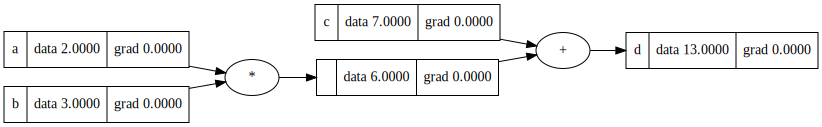

In [292]:
draw_dot(d)

In [293]:
e = a * b; e.label = 'e'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

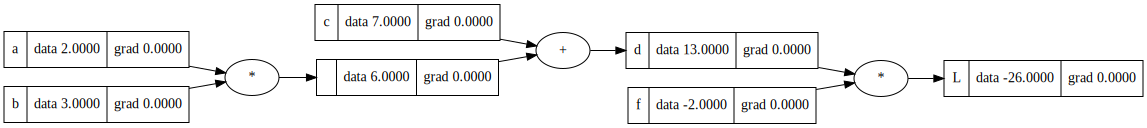

In [294]:
draw_dot(L)

In [295]:
h = 0.001

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

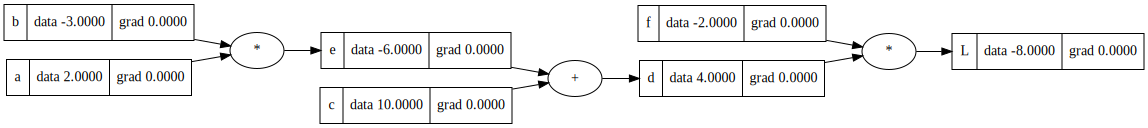

In [296]:
draw_dot(L)

In [297]:
# dL/dL
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  print((L2 - L1) / h)

lol()

1.000000000139778


In [298]:
L.grad = 1.0

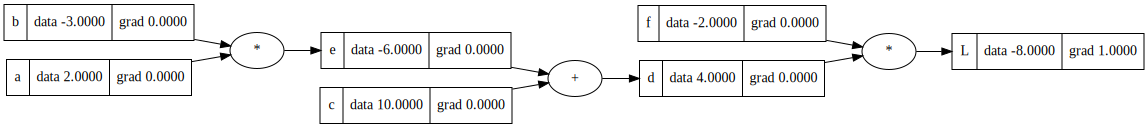

In [299]:
draw_dot(L)

In [300]:
# dL/dd
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-2.000000000279556


In [301]:
d.grad = -2.0

In [302]:
# dL/df
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

3.9999999996709334


In [303]:
f.grad = 4.0

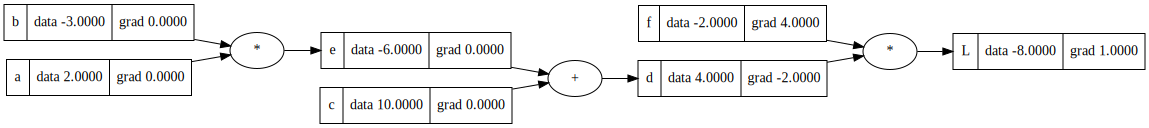

In [304]:
draw_dot(L)

In [305]:
# dL/de
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  e.data += h
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-2.000000000279556


In [306]:
e.grad = -2.0

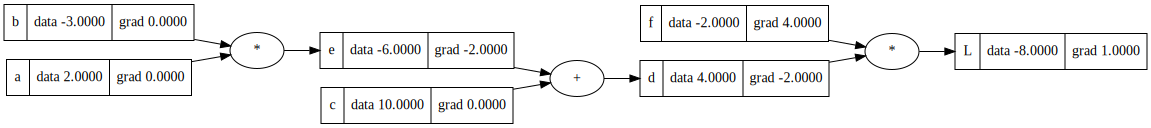

In [307]:
draw_dot(L)

In [308]:
# dL/dc
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data += h
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-1.999999998503199


In [309]:
c.grad = -2.0

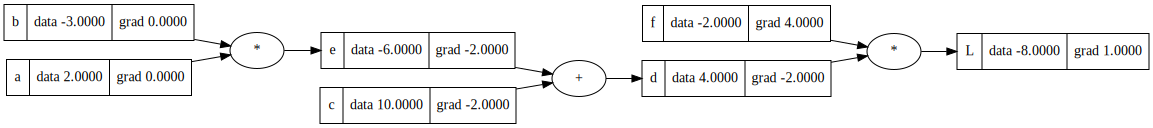

In [310]:
draw_dot(L)

In [311]:
# dL/da
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  a.data += h
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

6.000000000838668


In [312]:
a.grad = 6.0

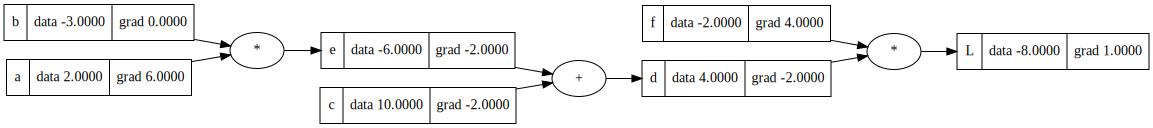

In [313]:
draw_dot(L)

In [314]:
# dL/db
def lol():

  h = 1e-6

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-4.000000000559112


In [315]:
b.data = -2.0

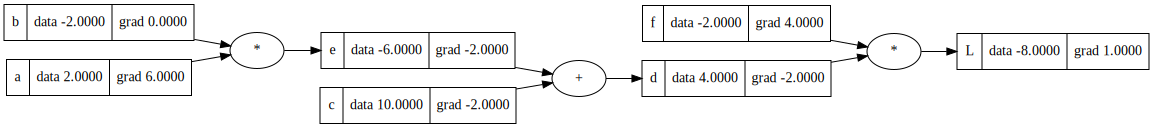

In [316]:
draw_dot(L)

In [317]:
print(f'a = {a}')
print(f'b = {b}')
print(f'c = {c}')
print(f'd = {d}')
print(f'e = {e}')
print(f'f = {f}')
print(f'L = {L}')

a = Value(data=2.0)
b = Value(data=-2.0)
c = Value(data=10.0)
d = Value(data=4.0)
e = Value(data=-6.0)
f = Value(data=-2.0)
L = Value(data=-8.0)


In [318]:
# var = var - (learning_rate) * dL/dvar
# var = var - (learning_rate) * var.grad
lr = 0.001
a.data -= lr * a.grad
b.data -= lr * a.grad
c.data -= lr * c.grad
d.data -= lr * d.grad
e.data -= lr * e.grad
f.data -= lr * f.grad

In [319]:
print(f'a = {a}')
print(f'b = {b}')
print(f'c = {c}')
print(f'd = {d}')
print(f'e = {e}')
print(f'f = {f}')
print(f'L = {L}')

a = Value(data=1.994)
b = Value(data=-2.006)
c = Value(data=10.002)
d = Value(data=4.002)
e = Value(data=-5.998)
f = Value(data=-2.004)
L = Value(data=-8.0)


In [320]:
# One forward pass
e = a * b
d = e + c
L = d * f

print(L.data)

-12.028080144000002


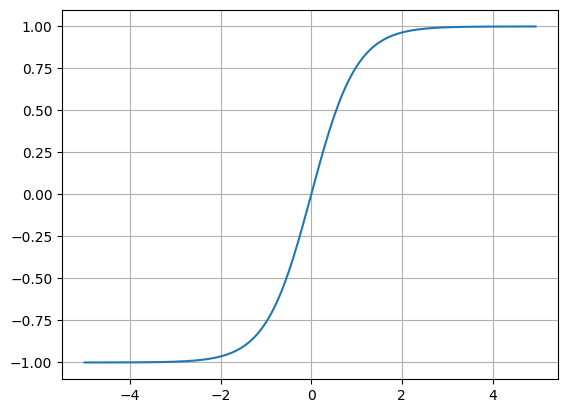

In [321]:
plt.plot(np.arange(-5, 5, 0.05), np.tanh(np.arange(-5, 5, 0.05))); plt.grid();

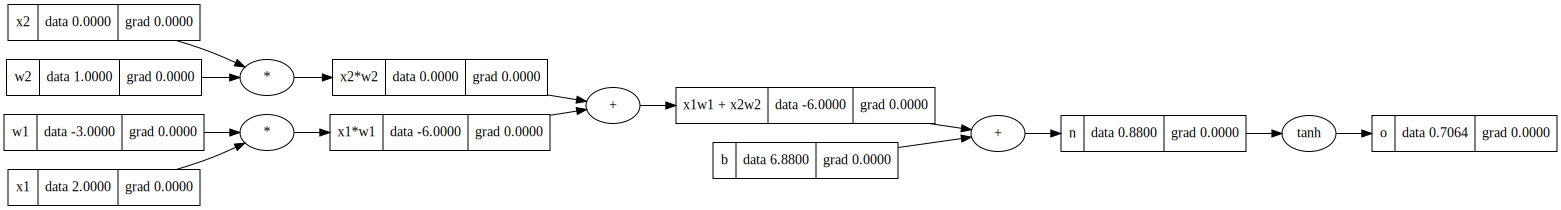

In [322]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.88, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [324]:
o.grad = 1.0

In [325]:
n.grad = 0.5

In [326]:
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [327]:
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [328]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

In [329]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

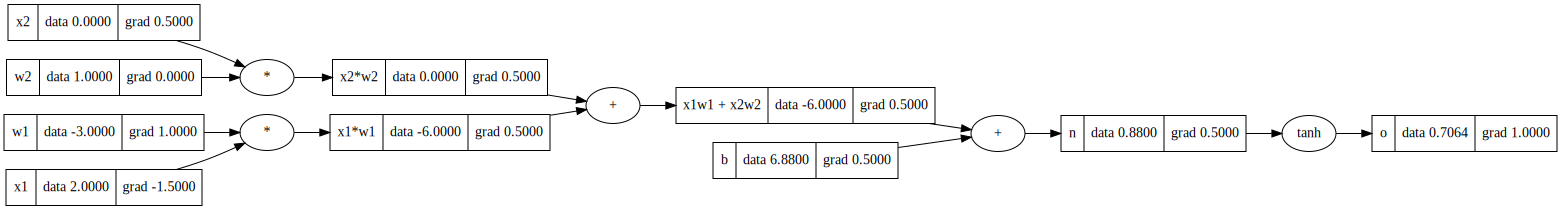

In [330]:
draw_dot(o)

In [334]:
# o = tanh(n)
# do/dn = 1 - tanh(n) ^ 2 = 1 - o**2
1 - o.data ** 2

0.5009717437695084